# Groundwater level data exploration

The aim here is to explore the raw data of the groundwater levels in the Lower Saxony State in Germany. 

In [2]:
#Import libraries
import geopandas as gpd
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
import os
from functions import *
import warnings

from IPython.display import Markdown as md

In [3]:
warnings.simplefilter(action='ignore', category=Warning)

In [4]:
rpath="C:/Users/GomezOspina.M/MGO/" #Root path

## Selection criteria
There is a pre-selection of well stations based on the "climatic hydrograph" method (agreement between the theoretical and observed hydrograph) and a proposal list from previous projects (KIT-BGR). The assessment contains subjective components, based on past analyses. This selection exclude wells under strong anthropogenic incluences such as pumping, allowing to assure a dependencz between the climatic input variables and the groundwater data.

In [5]:
#Import Groundwatwer stations
GW_CD_ID= gpd.read_file(rpath+"/data/GIS/SHP/GWL_CDID.shp")
GW_CD_sel=GW_CD_ID[GW_CD_ID.KLIGL_GRUP.isin([1,12,13])] # selection of stations in good agreement with climatic variables

total_wells= GW_CD_ID.shape[0]

In [6]:
total_wells= GW_CD_ID.shape[0]
sel_wells= GW_CD_sel.shape[0]
md(f"The data consists of a total of {total_wells} wells. \
   <br> After excluding the wells under anthropogenic influence:  {sel_wells} wells.")

The data consists of a total of 962 wells.    <br> After excluding the wells under anthropogenic influence:  745 wells.

### Load groundwater level data according to criteria

In [7]:
gwlist=[]
gidlist=[]
for gid in GW_CD_sel.MEST_ID : # Load data from selected IDs
    gw=readGWdata(gid,rpath +"/data/Grundwasserstandsdaten/Einzelmessstellen/")
    gwlist.append(gw)
    gidlist.append(gid)
    nonan=gw.GW_NN.count()
    index=GW_CD_sel.loc[GW_CD_sel.MEST_ID==gid].index.values[0]
    GW_CD_sel.loc[index, "nonan"]=nonan
gwdata_dic={"wellid":gidlist, "data":gwlist}
gwdata=pd.DataFrame(gwdata_dic)

##  Time range

This is used as a spatial overview of the data length

In [8]:
#Convert monthly measurements to annual assuming no gaps to check the time series length
GW_CD_sel["nonan_yr"]=GW_CD_sel["nonan"]/12

<IPython.core.display.Javascript object>


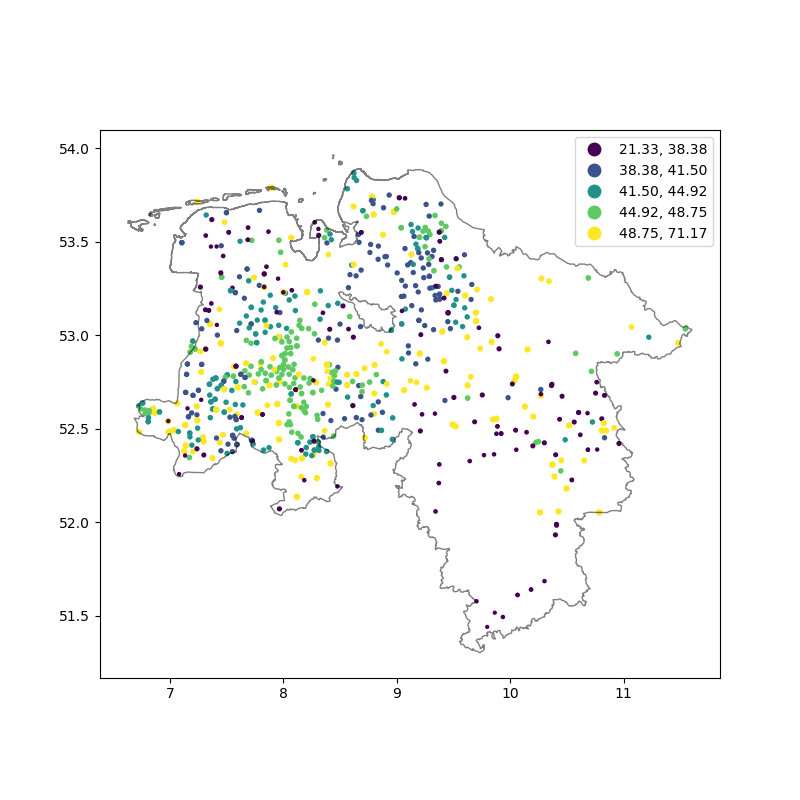

<AxesSubplot:>

In [8]:
#Plot GW stations with data information
germany_states = gpd.read_file(rpath+"/data/GIS/SHP/DEU_adm1.shp")
NS=germany_states[germany_states.NAME_1== "Niedersachsen"]
GW_CD_ID=GW_CD_ID.to_crs(epsg=4326)
GW_CD_sel=GW_CD_sel.to_crs(epsg=4326)
NSmap= NS.boundary.plot( figsize=(8, 8), alpha=0.5, edgecolor='k', linewidth=1)
#GW_CD_ID.plot(ax=NSmap,marker='*', color='c', markersize=8, label="GW")
GW_CD_sel.plot(ax=NSmap,column='nonan_yr',scheme="Quantiles", markersize=GW_CD_sel.nonan_yr.values/5,
         legend=True, label="GW_sel")



## Gaps length

Check the gap lengths to define the interpolation method

In [20]:
gaps_list=[]
count=[]
for i in range(sel_wells):
    gwdatam=gwdata.data[i].dropna(subset='GW_NN', inplace=False)#Drop nan values 
    deltas=gwdatam["DATUM"].diff()[1:]
    gaps = deltas[deltas > timedelta(days=31)]
    gaps_list.append(gaps)
    count.append(len(gaps))
    
gwdata["count"]=count
gwdata["gaps"]=gaps_list
gwdata["max_gap"]=gwdata.gaps.apply(lambda x: x.max().days)

In [21]:
#Estimate gap interval in days and months - 2 months means 1 missing data
gwdata["max_gap"]=gwdata.gaps.apply(lambda x: x.max().days)
gwdata["max_gap_months"]=gwdata.gaps.apply(lambda x: x.max().days/30)

<IPython.core.display.Javascript object>


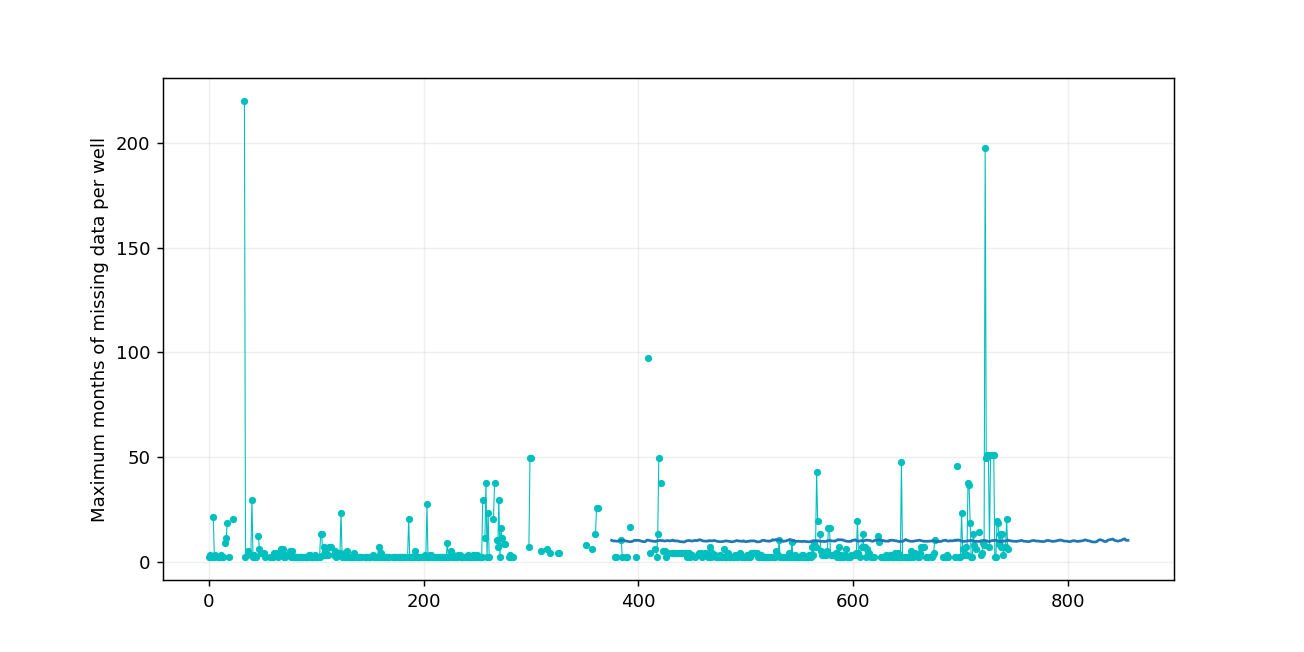

In [22]:
#Plot the maximum gap (in months) 
Fig= plt.figure(figsize=(10,5))
gwdata.max_gap_months.plot(marker='.', color="c", linewidth=0.6)
plt.ylabel("Maximum months of missing data per well")
plt.grid(True, alpha=0.2)

In [12]:
#Descriptive statistics
gwdata.max_gap_months.describe()

count    504.000000
mean       6.831878
std       16.190440
min        1.966667
25%        2.066667
50%        2.066667
75%        4.100000
max      220.200000
Name: max_gap_months, dtype: float64

<IPython.core.display.Javascript object>


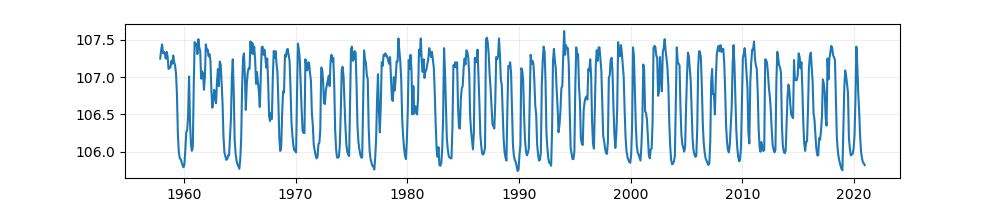

In [13]:
gwwell=gwdata.data[35]
Fig= plt.figure(figsize=(10,2))
plt.plot(gwwell["DATUM"], gwwell["GW_NN"])
plt.grid(True, alpha=0.2)

### Filter data with gaps longer than 4 months

In [14]:
gw_gapsel=gwdata[gwdata["max_gap"]<30*3]

In [15]:
GW_gapsel=GW_CD_sel[GW_CD_sel["MEST_ID"].isin(gw_gapsel["wellid"])]
GW_gapsel

,MEST_ID,MS_LBEZ,MS_MSA_ID,UTM_X,UTM_Y,MS_EIG,MS_BTR,MS_GOKNN,MS_FOK,MS_FUK,BGR_NSE_R2,BGR_REFERE,KLIGL_GRUP,AUSWAHL_KL,AUSWERTUNG,CD_ID_1,CD_ID_2,geometry,nonan,nonan_yr
1,9610009,Stollhamm,GWM,32457786.19,5930528.14,OOWV,NLWKN Brake-Oldenburg,1.20,19.20,20.20,Y,N,1,Y,KLIMGL_30JAHRE_1987_2017,2551,1223.0,POINT (8.36327 53.52198),584.0,48.666667
4,9610749,Delmenhorst-Langenwisch,GWM,32478507.19,5877458.91,Land Niedersachsen,NLWKN Brake-Oldenburg,6.19,19.60,21.60,N,N,1,Y,KLIMGL_30JAHRE_1987_2017,2841,1319.0,POINT (8.67940 53.04621),473.0,39.416667
7,9610875,Dykhausen,GWM,32431001.83,5929353.97,Land Niedersachsen,NLWKN Brake-Oldenburg,0.89,6.00,7.00,N,N,1,Y,KLIMGL_30JAHRE_1987_2017,1951,1023.0,POINT (7.95959 53.50860),568.0,47.333333
17,9700007,Auen-Holthaus,GWM,32413355.02,5854577.52,NLWKN,69,30.35,57.00,59.00,Y,N,1,Y,KLIMGL_30JAHRE_1987_2017,1637,817.0,POINT (7.71382 52.83398),562.0,46.833333
18,9700020,Beverbruch 3/6,GWM,32440656.13,5870819.37,NLWKN,69,15.59,28.21,30.21,Y,Y,1,Y,KLIMGL_30JAHRE_1987_2017,2140,1018.0,POINT (8.11605 52.98367),571.0,47.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
906,400080201,Zollbaum I,GWM,32501451.78,5954086.31,NLWKN,NLWKN Stade,5.23,7.00,13.00,None,None,13,Y,KLIMGL_20JAHRE_1997_2017_208_128,3356,1625.0,POINT (9.02201 53.73543),342.0,28.500000
919,9896004,Klingele_B4_Bgm-Itzen-Str,GWM,32390622.28,5892441.35,Klingele GmbH&Co.KG,NLWKN_AUR,0.53,2.00,3.00,None,None,13,Y,KLIMGL_20JAHRE_1997_2017_208_128,1144,621.0,POINT (7.36368 53.17008),343.0,28.583333
920,40000327,Rodenberg I,GWM,32525537.56,5795449.65,NLWKN Betriebsstelle Hannover-Hildesheim,NLWKN Betriebsstelle Hannover-Hildesheim,90.75,34.84,59.84,None,None,13,Y,KLIMGL_20JAHRE_1997_2017_208_128,3725,1611.0,POINT (9.37458 52.30879),336.0,28.000000
946,9700203,Osterlindern 7/1,GWM,32419467.64,5857189.89,NLWKN,69,38.86,36.00,38.00,None,None,13,Y,KLIMGL_20JAHRE_1997_2017_208_128,1737,818.0,POINT (7.80389 52.85841),562.0,46.833333


<IPython.core.display.Javascript object>


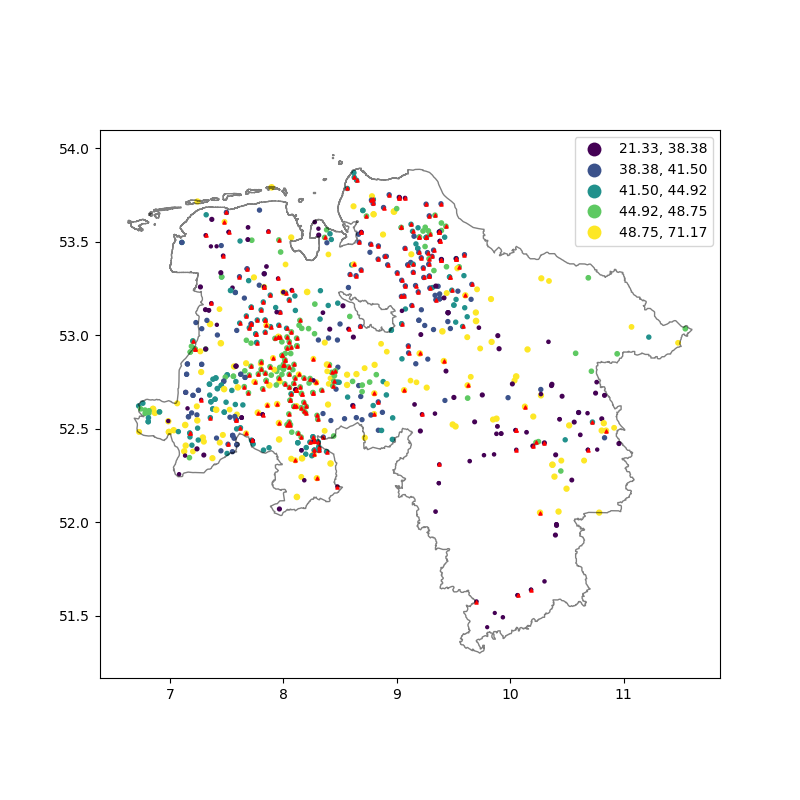

<AxesSubplot:>

In [16]:
#Plot GW stations with data information
germany_states = gpd.read_file(rpath+"/data/GIS/SHP/DEU_adm1.shp")
NS=germany_states[germany_states.NAME_1== "Niedersachsen"]
GW_CD_ID=GW_CD_ID.to_crs(epsg=4326)
GW_CD_sel=GW_CD_sel.to_crs(epsg=4326)
NSmap= NS.boundary.plot( figsize=(8, 8), alpha=0.5, edgecolor='k', linewidth=1)
#GW_CD_ID.plot(ax=NSmap,marker='*', color='c', markersize=8, label="GW")
GW_CD_sel.plot(ax=NSmap,column='nonan_yr',scheme="Quantiles", markersize=GW_CD_sel.nonan_yr.values/5,
         legend=True, label="GW_sel")
GW_gapsel.plot(ax=NSmap,marker="^", color= "red", markersize=5,label="GW_sel_filtered")

In [23]:
gwdata

,wellid,data,count,gaps,max_gap,max_gap_months
0,9610009,MEST_ID JAHR MONAT DATUM HJAHR H...,8,761 61 days 763 61 days 766 61 days 776 ...,62.0,2.066667
1,9610709,MEST_ID JAHR MONAT DATUM HJAHR H...,9,332 92 days 350 59 days 763 61 days 776 ...,92.0,3.066667
2,9610749,MEST_ID JAHR MONAT DATUM HJAHR H...,3,763 61 days 776 62 days 799 61 days Name...,62.0,2.066667
3,9610863,MEST_ID JAHR MONAT DATUM HJAHR H...,0,"Series([], Name: DATUM, dtype: timedelta64[ns])",NaN,NaN
4,9610873,MEST_ID JAHR MONAT DATUM HJAHR H...,1,"177 639 days Name: DATUM, dtype: timedelta64...",639.0,21.300000
...,...,...,...,...,...,...
740,500000530,MEST_ID JAHR MONAT DATUM HJAHR ...,4,350 90 days 756 61 days 814 92 days 816 ...,92.0,3.066667
741,500002800,MEST_ID JAHR MONAT DATUM HJAHR ...,46,324 92 days 337 123 days 342 91 days 3...,214.0,7.133333
742,600040461,MEST_ID JAHR MONAT DATUM HJAHR ...,10,350 90 days 364 213 days 605 92 days 6...,215.0,7.166667
743,600040801,MEST_ID JAHR MONAT DATUM HJAHR ...,13,364 213 days 510 274 days 522 365 days 5...,608.0,20.266667


In [28]:
##Save groundwater data
#gwdata.to_pickle(rpath+"/data/Pickle/gwdata.pkl") 
##Save grounwater stations filtered by gaps
#GW_gapsel.to_file(rpath+"/data/GIS/SHP/GWF.shp")